# WORDLE SOLVER

We use the words list available at https://gist.github.com/prichey/95db6bdef37482ba3f6eb7b4dec99101.
Then we pre-process the data: 

- We calculate the frequency of each single letter.
- We compute a score for each word. Words containing frequent letters have a higher score than words with less common letters
- The word with the highest score is the ideal word to type at first in Wordle. This happens to be 'arose' (with a couple of other words with the same score)

The steps above need to be executed only once. When we have the main DataFrame with the score of each word, we can use it for solving:

- We type the first word in the game ('arose'), and we get the result in terms of Black/Yellow/Green cells
- We pass these information to the solver, which will then remove words not complying with the results and return the next most probable word
- We repeat the process until we guess the actual hidden word



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## LOADING DATA

In [2]:
words = np.loadtxt('./wordle-words.txt', dtype=str)
print(f'{len(words)} words loaded.')

12972 words loaded.


## CALCULATING FREQUENCIES

In [3]:
freqs = np.zeros(26)
for word in words:
    chars = list(word)
    for char in chars:
        countidx = ord(char) - ord('a')
        freqs[countidx] = freqs[countidx] + 1

In [4]:
chars = []
for i in range(0, 26):
    chars.append(chr(i + ord('a')))   

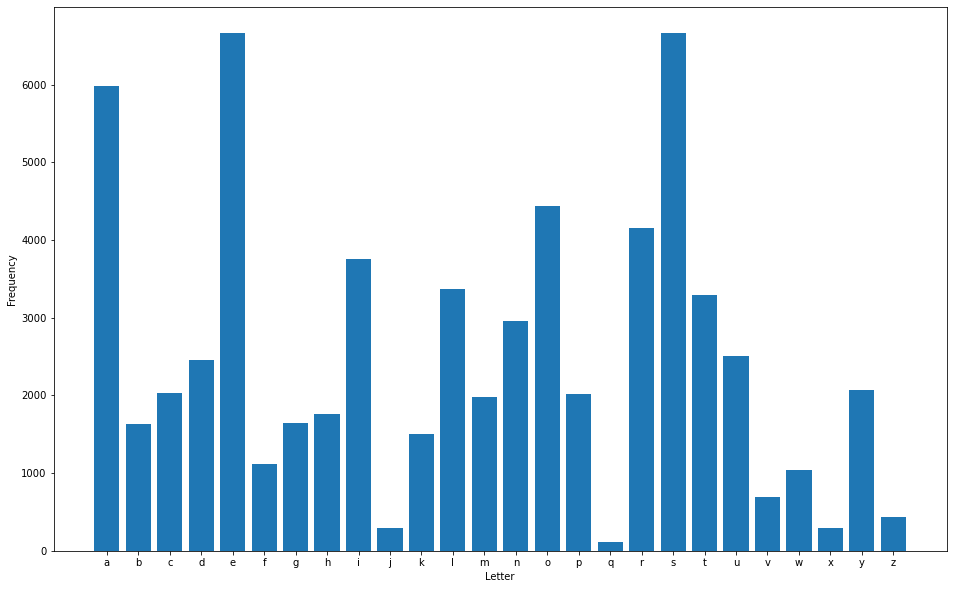

In [5]:
plt.figure(1, figsize=(16, 10))
plt.bar(chars, freqs)  
plt.ylabel('Frequency')
plt.xlabel('Letter');


In [6]:
def get_scores(words):
    scores = np.zeros(len(words))
    chars = np.empty(len(words), dtype=object)
    for index, word in enumerate(words):       
        chars[index] = set(word)
        for char in list(chars[index]):
            scores[index] += freqs[ord(char) - ord('a')]
    return scores, chars

In [7]:
scores, chars = get_scores(words)

In [8]:
# Sorting arrays on score
sortind = scores.argsort()
df = pd.DataFrame({
    'word': words[sortind[::-1]],
    'score': scores[sortind[::-1]],
    'chars': chars[sortind[::-1]]
})
df

,word,score,chars
0,arose,27913.0,"{a, r, e, o, s}"
1,soare,27913.0,"{r, a, e, o, s}"
2,aeros,27913.0,"{a, r, e, o, s}"
3,raise,27234.0,"{r, a, e, i, s}"
4,aesir,27234.0,"{a, r, e, i, s}"
...,...,...,...
12967,immix,6023.0,"{i, x, m}"
12968,hyphy,5853.0,"{y, h, p}"
12969,gyppy,5737.0,"{p, y, g}"
12970,xylyl,5733.0,"{y, x, l}"


In [9]:
# My favourite word is 159th
df[df.word == 'sepia']

,word,score,chars
159,sepia,25095.0,"{a, e, i, s, p}"


## SOLVING

In [10]:
# Legend:
#   B: Black  -> that character is not in the word
#   Y: Yellow -> that character is in the word but in a different position
#   G: Green  -> that character is in the correct position
def drop_words(df, dontHaveList, haveInPlaceRegex, haveOutPlaceRegex):
    ret = df

    # Drop words that have at least one of the B characters
    chars = set(dontHaveList)
    for char in chars:
        ret = ret.loc[(ret.chars & {char} == False)]

    # Drop words that don't have the G characters in position 
    ret = ret[ret.word.str.match(haveInPlaceRegex)]                      
                      
    # Drop words that have a Y characters in that position (it would have been G)
    for index, char in enumerate(haveOutPlaceRegex):
        ret = ret.loc[ret.word.str.get(index) != char]
        
    # Drop words that do not have the Y characters
    chars = set(haveOutPlaceRegex)
    for char in chars:
        if (char != '.'):
            ret = ret.loc[(ret.chars & {char})] 
        
    return ret

In [11]:
def guessed_word(word, result):
    
    dontHaveList = ''
    haveInPlaceRegex = bytearray('.....', encoding="utf-8")
    haveOutPlaceRegex = bytearray('.....', encoding="utf-8")
    
    for index, char in enumerate(word):
        if result[index] == 'B':
            dontHaveList += char
        elif result[index] == 'Y':
            haveOutPlaceRegex[index] = ord(char)
        elif result[index] == 'G':
            haveInPlaceRegex[index] = ord(char)

    return dontHaveList, bytearray.decode(haveInPlaceRegex), bytearray.decode(haveOutPlaceRegex)

In [12]:
def solve(df, word, result):
    dontHave, haveInPlace, haveOutPlace = guessed_word(word, result)
    ret = drop_words(df, dontHave, haveInPlace, haveOutPlace)
    print(f'{len(ret)} words remaining. Try: "{ret.iloc[0].word}"')
    return ret

## EXAMPLE 1

 Wordle 229: Typed 'arose' and got 'YYBYB'

In [13]:
w1 = solve(df, 'arose', 'YYBYB')

251 words remaining. Try: "rails"


In [14]:
w2 = solve(w1, 'rails', 'YYBBY')

55 words remaining. Try: "starn"


In [15]:
w3 = solve(w2, 'starn', 'GBGGB')

12 words remaining. Try: "spard"


In [16]:
w4 = solve(w3, 'spard', 'GBGGG')

2 words remaining. Try: "shard"


**SHARD!**

## EXAMPLE 2

Wordle 226: Typed 'arose' and got 'BBBBB'

In [17]:
w1 = solve(df, 'arose', 'BBBBB')

577 words remaining. Try: "unlit"


In [18]:
w2 = solve(w1, 'unlit', 'BBYYG')

7 words remaining. Try: "clipt"


In [19]:
w3 = solve(w2, 'clipt', 'BYYBG')

1 words remaining. Try: "light"


**LIGHT!**